# Chapter 3
## Ex. 1 & 2: MNIST Classification

In [1]:
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

import urllib.request
import tarfile

## 1. Building a classifier for the MNIST dataset that achieves over 97% accuracy

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

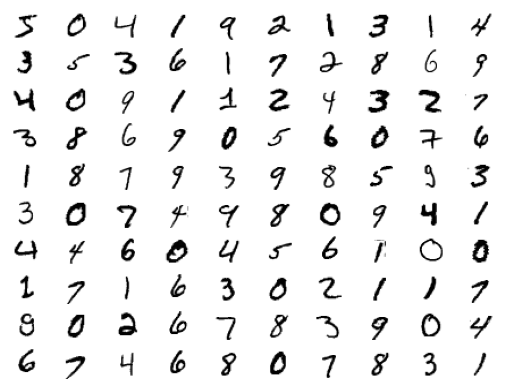

In [3]:
def plot_digit(image_data):
    plt.imshow(image_data.reshape(28, 28), cmap="binary")
    plt.axis("off")


plt.figure()
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

plt.show()

In [4]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [5]:
param_grid = {
    "standardscaler__with_mean": [False],  # maintains sparsity
    "standardscaler__with_std": [True, False],
    "kneighborsclassifier__n_neighbors": [3, 4, 5, 6],
    "kneighborsclassifier__p": [1, 2, 3],
    "kneighborsclassifier__weights": ["uniform", "distance"],
}

grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=3, verbose=3)

In [6]:
model_name = "03_mnist_grid_search"
model_path = Path(f"models/{model_name}.pkl")

if model_path.is_file():
    grid_search = joblib.load(model_path)
else:
    grid_search.fit(X_train[:10_000], y_train[:10_000])
    joblib.dump(grid_search, model_path)

grid_search.best_score_

0.9431995689071008

In [7]:
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 4,
 'kneighborsclassifier__p': 3,
 'kneighborsclassifier__weights': 'distance',
 'standardscaler__with_mean': False,
 'standardscaler__with_std': False}

In [8]:
grid_search_cv_results = pd.DataFrame(grid_search.cv_results_)
grid_search_cv_results.columns = grid_search_cv_results.columns.str.split("__").str[-1]

grid_search_cv_results = grid_search_cv_results[
    (grid_search_cv_results["weights"] == "distance")
    & (grid_search_cv_results["with_mean"] == False)
    & (grid_search_cv_results["with_std"] == False)
].drop(
    columns=[
        "mean_score_time",
        "std_score_time",
        "params",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "weights",
        "with_mean",
        "with_std",
    ]
)

grid_search_cv_results.head()

,mean_fit_time,std_fit_time,n_neighbors,p,mean_test_score,std_test_score,rank_test_score
3,0.031383,0.000542,3,1,0.929400,0.008985,18
7,0.031909,0.000114,3,2,0.938500,0.007478,8
11,0.031559,0.000197,3,3,0.942599,0.009332,2
15,0.031125,0.000554,4,1,0.931800,0.007423,17
19,0.032167,0.000683,4,2,0.939799,0.008137,6


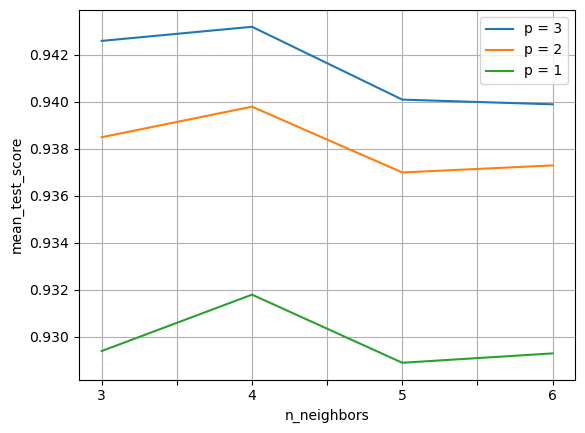

In [9]:
fig, ax = plt.subplots()

for p_value in reversed(grid_search_cv_results["p"].unique()):
    grid_search_cv_results[grid_search_cv_results["p"] == p_value].plot(
        x="n_neighbors", y="mean_test_score", ax=ax, label=f"p = {p_value}"
    )

plt.xlabel("n_neighbors")
plt.ylabel("mean_test_score")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 4,
 'kneighborsclassifier__p': 3,
 'kneighborsclassifier__weights': 'distance',
 'standardscaler__with_mean': False,
 'standardscaler__with_std': False}

In [11]:
param_grid2 = {
    "standardscaler__with_mean": [False],  # maintains sparsity
    "standardscaler__with_std": [False],
    "kneighborsclassifier__n_neighbors": [4],
    "kneighborsclassifier__p": [10, 11, 12, 13, 14],
    "kneighborsclassifier__weights": ["distance"],
}

grid_search = GridSearchCV(model, param_grid2, scoring="accuracy", cv=3, verbose=3)

model_name = "03_mnist_grid_search2"
model_path = Path(f"models/{model_name}.pkl")

if model_path.is_file():
    grid_search = joblib.load(model_path)
else:
    grid_search.fit(X_train[:10_000], y_train[:10_000])
    joblib.dump(grid_search, model_path)

grid_search.best_score_

0.9476995689970916

In [12]:
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 4,
 'kneighborsclassifier__p': 12,
 'kneighborsclassifier__weights': 'distance',
 'standardscaler__with_mean': False,
 'standardscaler__with_std': False}

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_kneighborsclassifier__n_neighbors',
       'param_kneighborsclassifier__p', 'param_kneighborsclassifier__weights',
       'param_standardscaler__with_mean', 'param_standardscaler__with_std',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


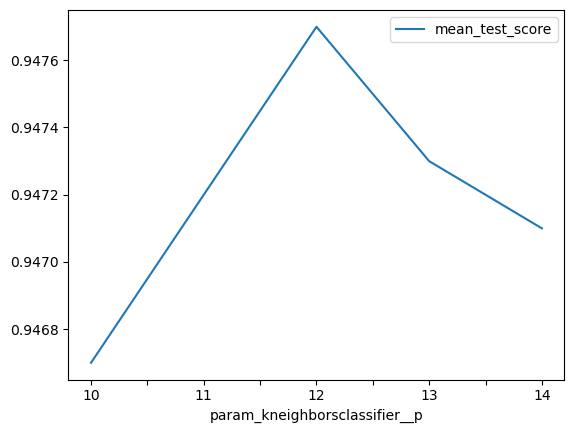

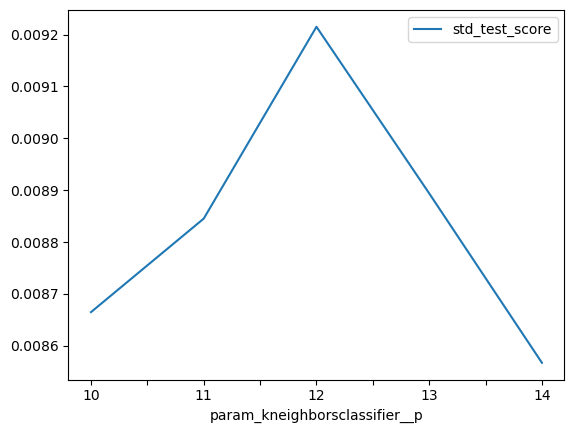

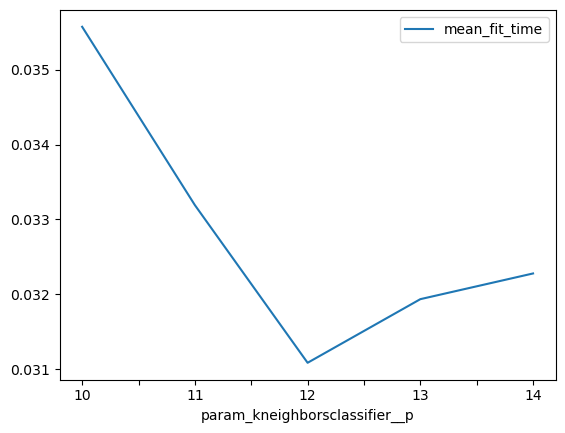

In [13]:
grid_search_cv_results = pd.DataFrame(grid_search.cv_results_)
grid_search_cv_results.plot(x="param_kneighborsclassifier__p", y="mean_test_score")
grid_search_cv_results.plot(x="param_kneighborsclassifier__p", y="std_test_score")
grid_search_cv_results.plot(x="param_kneighborsclassifier__p", y="mean_fit_time")

print(grid_search_cv_results.columns)

In [14]:
model_name = "03_y_test_predicted"
model_path = Path(f"models/{model_name}.pkl")

if model_path.is_file():
    y_test_predicted = joblib.load(model_path)
else:
    grid_search.best_estimator_.fit(X_train, y_train)
    y_test_predicted = grid_search.predict(X_test)
    joblib.dump(y_test_predicted, model_path)

In [15]:
print(
    f"accuracy_score: {accuracy_score(y_test, y_test_predicted)}",
    f"precision_score: {precision_score(y_test, y_test_predicted, average='macro')}",
    f"recall_score: {recall_score(y_test, y_test_predicted, average='macro')}",
    f"f1_score: {f1_score(y_test, y_test_predicted, average='macro')}",
    sep="\n",
)

accuracy_score: 0.9752
precision_score: 0.9752495216317352
recall_score: 0.9750096170347919
f1_score: 0.9750975117555647


## 2. Data Augmentation

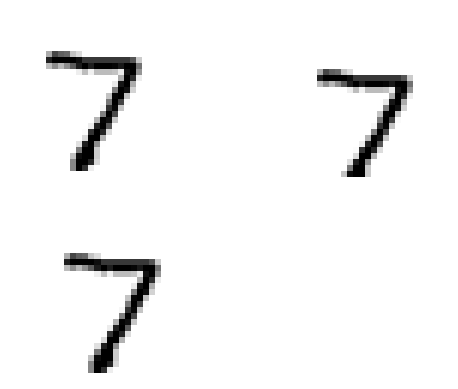

In [16]:
def shift(image_data, direction=(0, 0)):
    image = image_data.reshape(28, 28)

    if direction[0] > 0:
        image = np.hstack(
            (
                np.zeros((28, abs(direction[0]))),
                image[:, : -direction[0]],
            )
        )

    elif direction[0] < 0:
        image = np.hstack(
            (
                image[:, -direction[0] :],
                np.zeros((28, abs(direction[0]))),
            )
        )

    if direction[1] > 0:
        image = np.vstack(
            (
                image[direction[1] :, :],
                np.zeros((abs(direction[1]), 28)),
            )
        )

    elif direction[1] < 0:
        image = np.vstack(
            (
                np.zeros((abs(direction[1]), 28)),
                image[: direction[1], :],
            )
        )

    return image.reshape(784)


plt.figure()

plt.subplot(2, 2, 1)
plot_digit(X_test[0])

plt.subplot(2, 2, 2)
plot_digit(shift(X_test[0], direction=(0, -3)))

plt.subplot(2, 2, 3)
plot_digit(shift(X_test[0], direction=(3, 0)))

In [17]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for direction in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift(image, direction))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [18]:
model_name = "03_y_test_predicted_augmented"
model_path = Path(f"models/{model_name}.pkl")

if model_path.is_file():
    y_test_predicted_aug = joblib.load(model_path)
else:
    grid_search.best_estimator_.fit(X_train_augmented, y_train_augmented)
    y_test_predicted_aug = grid_search.predict(X_test)
    joblib.dump(y_test_predicted, model_path)

In [19]:
print(
    f"accuracy_score: {accuracy_score(y_test, y_test_predicted_aug)}",
    f"precision_score: {precision_score(y_test, y_test_predicted_aug, average='macro')}",
    f"recall_score: {recall_score(y_test, y_test_predicted_aug, average='macro')}",
    f"f1_score: {f1_score(y_test, y_test_predicted_aug, average='macro')}",
    sep="\n",
)

accuracy_score: 0.9818
precision_score: 0.9817858533737164
recall_score: 0.9815691285829334
f1_score: 0.9816646659268333


In [20]:
print(
    f"Accuracy improvement: {(accuracy_score(y_test, y_test_predicted_aug) - accuracy_score(y_test, y_test_predicted)):.2%}"
)

Accuracy improvement: 0.66%


In [21]:
error_rate_change = (1 - accuracy_score(y_test, y_test_predicted_aug)) / (
    1 - accuracy_score(y_test, y_test_predicted)
) - 1
print(f"error rate change: {error_rate_change:.0%}")

error rate change: -27%
